In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import argparse
from pydrake.all import (
    Meshcat,
    StartMeshcat,
    Simulator,
    DiagramBuilder,
    Diagram,
    MeshcatVisualizer,
    RigidTransform,
    RotationMatrix,
    PortSwitch,
)
from omegaconf import DictConfig
from src.stations.setup_station import get_scenario
from src.modules.perception import MergePointClouds, LNDFGrasper
import logging
import os
import random
import numpy as np
from manipulation.station import (
    DepthImageToPointCloud, MakeHardwareStation, LoadScenario, AddPointClouds, AppendDirectives
)
from debug import visualize_camera_images, visualize_depth_images, visualize_point_cloud, draw_grasp_candidate, draw_query_pts
import hydra
import plotly.express as px
from hydra.utils import get_original_cwd
from src.modules.kinematics import Planner, AddPandaDifferentialIK
from omegaconf import OmegaConf
from manipulation.utils import RenderDiagram

In [3]:
class NoDiffIKWarnings(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith("Differential IK")

In [29]:
def BuildPouringDiagram(meshcat: Meshcat, cfg: DictConfig) -> tuple[Diagram, Diagram, ]:
    scenario_cfg = cfg['directives']
    lndf_config = cfg['lndf']

    builder = DiagramBuilder()

    scenario_data = get_scenario(scenario_cfg)
    scenario = LoadScenario(data=scenario_data)
    panda_station = MakeHardwareStation(scenario, meshcat)
    station = builder.AddSystem(panda_station)

    plant = station.GetSubsystemByName("plant")

    merge_point_clouds = builder.AddNamedSystem(
        "merge_point_clouds",
        MergePointClouds(
            plant,
            plant.GetModelInstanceByName("basket"),

            # only above view cameras to get partial point clouds
            camera_body_indices=[
                plant.GetBodyIndices(plant.GetModelInstanceByName("camera0"))[0],
                plant.GetBodyIndices(plant.GetModelInstanceByName("camera1"))[0],
                plant.GetBodyIndices(plant.GetModelInstanceByName("camera2"))[0],
                # plant.GetBodyIndices(plant.GetModelInstanceByName("camera3"))[0], # remove bottom "cheat" camera
            ],
            meshcat=meshcat,
        ),
    )

    to_point_cloud = AddPointClouds(
        scenario=scenario, station=station, builder=builder, meshcat=meshcat
    )

    grasper = builder.AddNamedSystem(
        "grasper", LNDFGrasper(lndf_config, plant, meshcat)
    )

    builder.Connect(
        merge_point_clouds.GetOutputPort("point_cloud"),
        grasper.GetInputPort("merged_point_cloud"),
    )

    for i in range(3):
        camera_idx = f"camera{i}"
        point_cloud_port = f"camera{i}_point_cloud"
        builder.Connect(
            to_point_cloud[camera_idx].get_output_port(),
            merge_point_clouds.GetInputPort(point_cloud_port),
        )

    builder.Connect(
        panda_station.GetOutputPort("body_poses"),
        merge_point_clouds.GetInputPort("body_poses"),
    )

    # Planner
    # planner = builder.AddSystem(Planner(meshcat, plant))
    # builder.Connect(
    #     panda_station.GetOutputPort("body_poses"),
    #     planner.GetInputPort("body_poses")
    # )
    # builder.Connect(
    #     grasper.GetOutputPort("grasp_pose"),
    #     planner.GetInputPort("basket_grasp")
    # )

    # builder.Connect(
    #     station.GetOutputPort("panda_hand_state"),
    #     planner.GetInputPort("hand_state")
    # )
    # builder.Connect(
    #     station.GetOutputPort("panda_arm_state"),
    #     planner.GetInputPort("panda_position")
    # )

    # builder.Connect(
    #     station.GetOutputPort("panda_arm_torque_external"),
    #     planner.GetInputPort("external_torque")
    # )

    # robot = station.GetSubsystemByName("panda_controller").get_multibody_plant_for_control()

    # DiffIK
    # diff_ik = AddPandaDifferentialIK(builder, robot)
    # builder.Connect(
    #     planner.GetOutputPort("X_WG"),
    #     diff_ik.GetInputPort("X_AE_desired")
    # )
    # builder.Connect(
    #     station.GetOutputPort("panda_arm_state"),
    #     diff_ik.GetInputPort("robot_state")
    # )

    # builder.Connect(planner.GetOutputPort("reset_diff_ik"),
    #                 diff_ik.GetInputPort("use_robot_state"))
    # builder.Connect(planner.GetOutputPort("hand_position"),
    #                 station.GetInputPort("panda_hand_state"))
    
    # switch between direct control and diff ik
    # switch = builder.AddSystem(PortSwitch(7))
    # builder.Connect(
    #     diff_ik.get_output_port(),
    #     switch.DeclareInputPort("diff_ik")
    # )
    # builder.Connect(planner.GetOutputPort("panda_position_command"),
    #                 switch.DeclareInputPort("position"))
    # builder.Connect(switch.get_output_port(),
    #                 station.GetInputPort("panda_arm_position"))
    # builder.Connect(planner.GetOutputPort("control_mode"),
    #                 switch.get_port_selector_input_port())

    #Debug: visualize camera images
    # visualize_camera_images(station)

    # Debug: visualize depth images
    # visualize_depth_images(station)

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, station.GetOutputPort("query_object"), meshcat
    )

    return builder.Build(), None, visualizer

In [42]:
def pouring_demo(cfg: DictConfig) -> bool:
    meshcat = StartMeshcat()

    diagram, plant, visualizer = BuildPouringDiagram(meshcat, cfg)
    context = diagram.CreateDefaultContext()


    # debug: fix the input to station
    station = diagram.GetSubsystemByName("station")
    panda_arm_hand_desired_state = station.GetInputPort("panda_arm+panda_hand.desired_state")

    print(panda_arm_hand_desired_state)
    print(panda_arm_hand_desired_state.size())
    

    RenderDiagram(diagram, max_depth=1)
    raise RuntimeError

    # debug: visualize merged point cloud
    merge_point_clouds = diagram.GetSubsystemByName('merge_point_clouds')
    context = merge_point_clouds.GetMyContextFromRoot(diagram.CreateDefaultContext())
    pc = merge_point_clouds.GetOutputPort('point_cloud').Eval(context)
    # np.save(f'{get_original_cwd()}/outputs/basket_merged_point_cloud.npy', pc.xyzs())
    fig = px.scatter_3d(x = pc.xyzs()[0,:], y=pc.xyzs()[1,:], z=pc.xyzs()[2,:])
    fig.show()

    simulator = Simulator(diagram, context)

    simulator.AdvanceTo(0.6)
    meshcat.Flush()  # Wait for the large object meshes to get to meshcat.
    visualizer.StartRecording()

    # run as fast as possible
    simulator.set_target_realtime_rate(0)
    meshcat.AddButton("Stop Simulation", "Escape")
    print("Press Escape to stop the simulation")

    # draw pose of gripper in initial pose
    station = diagram.GetSubsystemByName("PandaManipulationStation")

    print('Running Simulation')

    while meshcat.GetButtonClicks("Stop Simulation") < 1:
        if cfg.max_time != -1 and simulator.get_context().get_time() > cfg.max_time:
            raise Exception("Took too long")
        simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)
        # stats = diagram.get_output_port().Eval(simulator.get_context())
        visualizer.StopRecording()
    visualizer.PublishRecording()
    meshcat.DeleteButton("Stop Simulation")
    return True

INFO:drake:Meshcat listening for connections at http://localhost:7016


{'directives': {'num_balls': 3}, 'max_time': -1, 'lndf': {'pc_sample_pts': 2000, 'eval_dir': 'outputs', 'pose_optimizer': {'opt_type': 'LNDF', 'args': {'opt_iterations': 500, 'rand_translate': True, 'use_tsne': False, 'M_override': 20}}, 'query_point': {'type': 'RECT', 'args': {'n_pts': 1000, 'x': 0.08, 'y': 0.04, 'z1': 0.05, 'z2': 0.02}}, 'model': {'type': 'CONV_OCC', 'args': {'latent_dim': 128, 'model_type': 'pointnet', 'return_features': True, 'sigmoid': False, 'acts': 'last'}, 'ckpt': 'lndf_weights.pth'}}}


[ 0.201  0.299 -0.299] [ 0.799 -0.299  0.699]
Using CONV OCC
model_ckpt:  /Users/ericchen/Eric/BallPitNDF/src/modules/grasping/lndf_robot/ckpts/lndf_weights.pth
Using Occ Net optimizer


/Users/ericchen/Eric/BallPitNDF/src/modules/grasping/pose_selector.py:89: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



18


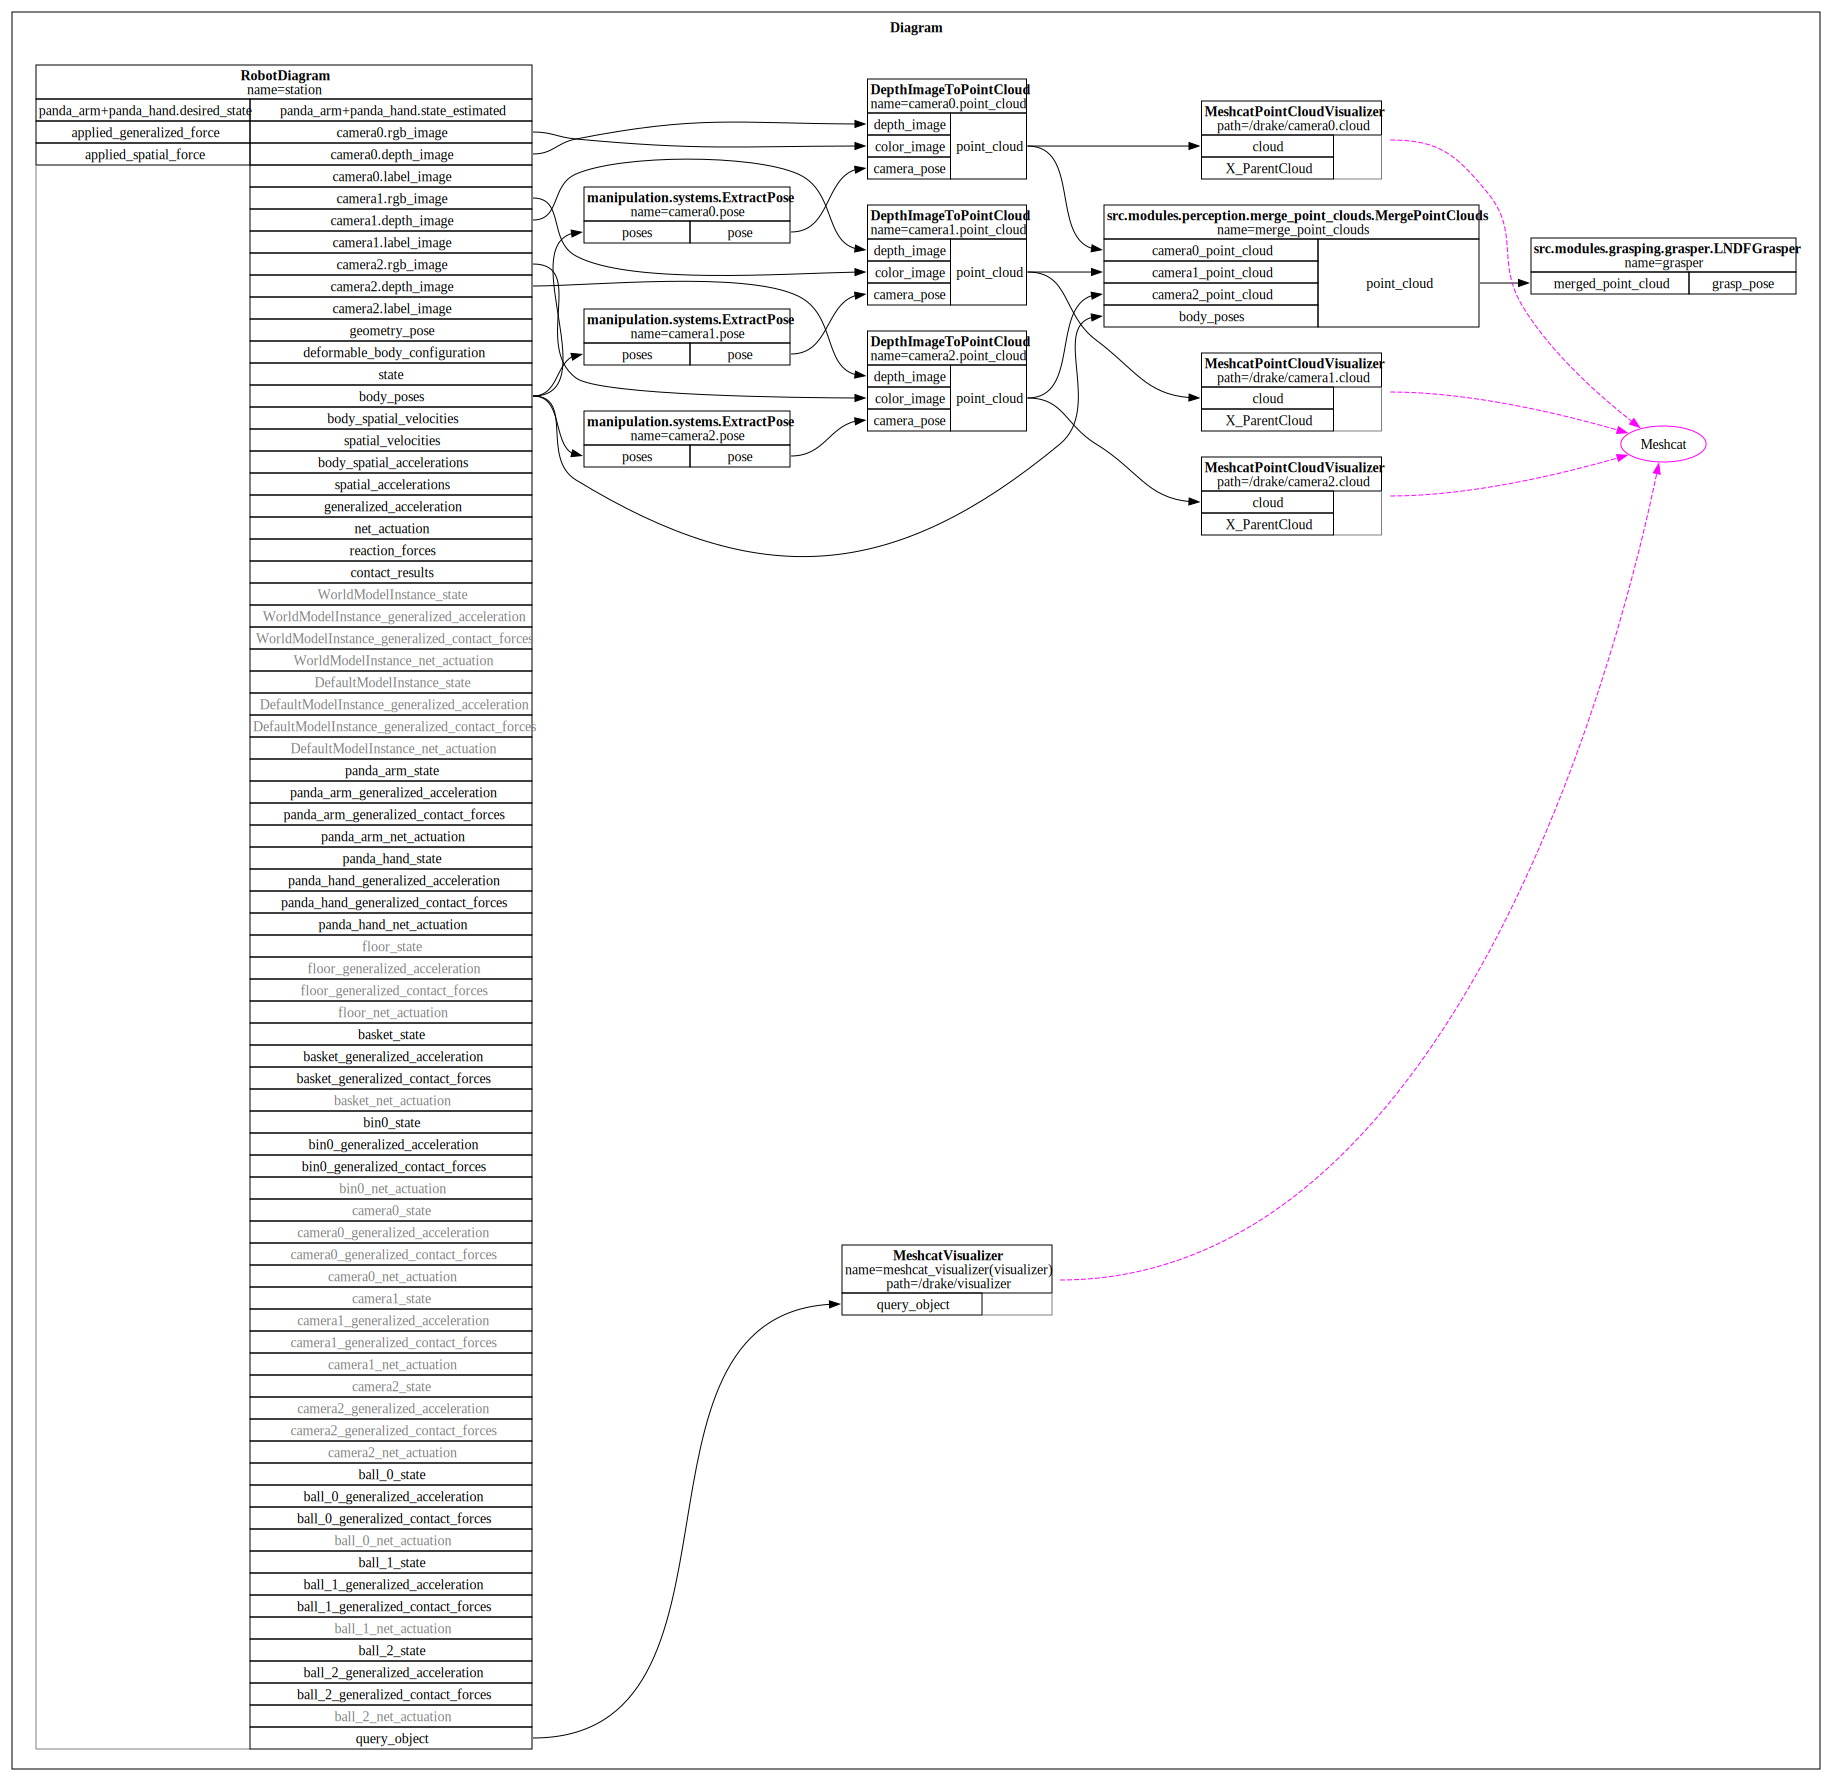

RuntimeError: 

In [43]:
cfg = OmegaConf.load("./src/config/pouring.yaml")
print(cfg)

pouring_demo(cfg)